<a href="https://colab.research.google.com/github/skrakibulislamrahat/Lightweight_DR_Detection_Models-Models/blob/main/Lightweight_DR_Model_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 Lightweight DR Detection Models (MobileNetV2, EfficientNetB0, SqueezeNet)
**Using APTOS Dataset - Output Saved to Google Drive**

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define project root and subfolders
PROJECT_ROOT = "/content/drive/My Drive/Colab_Notebooks/DR_Project_Model"
SUBFOLDERS = ["checkpoints", "logs", "outputs", "metrics", "figures"]

# Create organized structure
for folder in SUBFOLDERS:
    os.makedirs(os.path.join(PROJECT_ROOT, folder), exist_ok=True)

print("✅ Folders created:")
for folder in SUBFOLDERS:
    print(f" - {folder}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Folders created:
 - checkpoints
 - logs
 - outputs
 - metrics
 - figures


In [ ]:
!pip install -q timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.9 MB/s eta 0:00:00


In [ ]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import timm

In [ ]:
# General config
MODEL_NAME = "efficientnet_b0"  # You can switch to mobilenetv2 or squeezenet1_0 later
BASE_DIR = "/content/drive/My Drive/Colab_Notebooks/DR_Project"
IMG_DIR = f"{BASE_DIR}/train_images"
CSV_PATH = f"{BASE_DIR}/train.csv"
RESULTS_DIR = f"{BASE_DIR}/Results/{MODEL_NAME}"

# Create results folders
os.makedirs(RESULTS_DIR, exist_ok=True)
for folder in ["checkpoints", "metrics", "figures"]:
    os.makedirs(os.path.join(RESULTS_DIR, folder), exist_ok=True)

# Model/Training params
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = 224
NUM_CLASSES = 2  # binary classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv(CSV_PATH)
df.columns = ['image', 'level']  # Ensure column names
df['binary_label'] = df['level'].apply(lambda x: 0 if x <= 1 else 1)  # 0: no/mild, 1: referable

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
class DRBinaryDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.img_dir, row['image'] + ".png")
        image = Image.open(image_path).convert("RGB")

        label = int(row['binary_label'])

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['binary_label'], random_state=42)

train_dataset = DRBinaryDataset(train_df.reset_index(drop=True), IMG_DIR, transform)
val_dataset = DRBinaryDataset(val_df.reset_index(drop=True), IMG_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Train samples: {len(train_dataset)}")
print(f"✅ Val samples: {len(val_dataset)}")

✅ Train samples: 2929
✅ Val samples: 733


In [ ]:
class DRModel(nn.Module):
    def __init__(self):
        super(DRModel, self).__init__()
        self.model = timm.create_model(MODEL_NAME, pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

model = DRModel().to(device)
print(f"✅ {MODEL_NAME} initialized.")

✅ efficientnet_b0 initialized.


In [ ]:
from tqdm import tqdm
import copy

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float('inf')
train_history = {"train_loss": [], "val_loss": [], "val_acc": []}
best_model_path = os.path.join(RESULTS_DIR, "checkpoints", "best_model.pth")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, correct = 0.0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    # Track history
    train_history["train_loss"].append(train_loss)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("✅ Best model updated!")

# Save training history
history_path = os.path.join(RESULTS_DIR, "metrics", "history.json")
with open(history_path, "w") as f:
    json.dump(train_history, f)

print(f"\n✅ Training complete. Best model saved at:\n{best_model_path}")

Epoch 1/10: 100%|██████████| 92/92 [19:12<00:00, 12.52s/it]


[1/10] Train Loss: 0.2893 | Val Loss: 0.1698 | Val Acc: 0.9250
✅ Best model updated!


Epoch 2/10: 100%|██████████| 92/92 [05:30<00:00,  3.59s/it]


[2/10] Train Loss: 0.1219 | Val Loss: 0.1790 | Val Acc: 0.9318


Epoch 3/10: 100%|██████████| 92/92 [05:25<00:00,  3.54s/it]


[3/10] Train Loss: 0.0587 | Val Loss: 0.1955 | Val Acc: 0.9236


Epoch 4/10: 100%|██████████| 92/92 [05:28<00:00,  3.57s/it]


[4/10] Train Loss: 0.0321 | Val Loss: 0.2330 | Val Acc: 0.9277


Epoch 5/10: 100%|██████████| 92/92 [05:28<00:00,  3.57s/it]


[5/10] Train Loss: 0.0206 | Val Loss: 0.2330 | Val Acc: 0.9318


Epoch 6/10: 100%|██████████| 92/92 [05:26<00:00,  3.55s/it]


[6/10] Train Loss: 0.0110 | Val Loss: 0.2855 | Val Acc: 0.9181


Epoch 7/10: 100%|██████████| 92/92 [05:29<00:00,  3.58s/it]


[7/10] Train Loss: 0.0157 | Val Loss: 0.3076 | Val Acc: 0.9318


Epoch 8/10: 100%|██████████| 92/92 [05:31<00:00,  3.61s/it]


[8/10] Train Loss: 0.0190 | Val Loss: 0.3116 | Val Acc: 0.9263


Epoch 9/10: 100%|██████████| 92/92 [05:34<00:00,  3.63s/it]


[9/10] Train Loss: 0.0074 | Val Loss: 0.3134 | Val Acc: 0.9332


Epoch 10/10: 100%|██████████| 92/92 [05:32<00:00,  3.61s/it]


[10/10] Train Loss: 0.0104 | Val Loss: 0.3419 | Val Acc: 0.9332

✅ Training complete. Best model saved at:
/content/drive/My Drive/Colab_Notebooks/DR_Project/Results/efficientnet_b0/checkpoints/best_model.pth


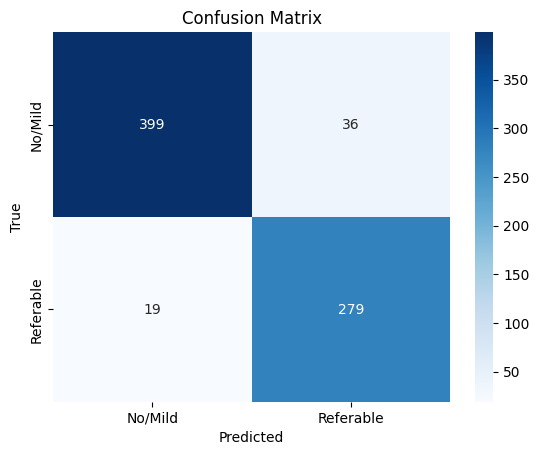

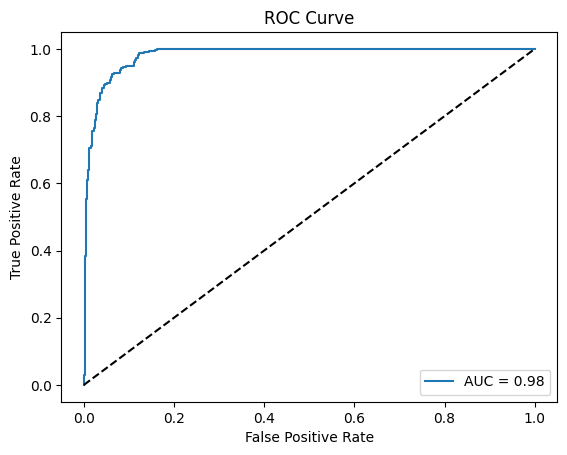

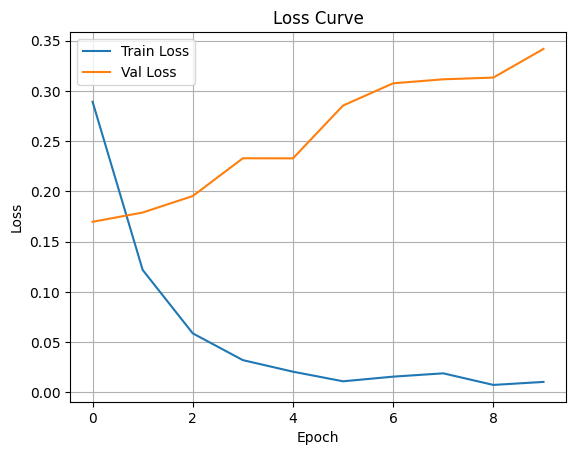

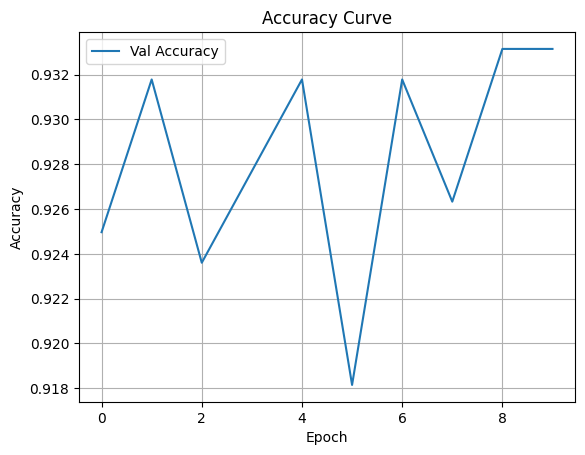

✅ All evaluations done and saved:
- Confusion Matrix → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/efficientnet_b0/figures/confusion_matrix.png
- ROC Curve → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/efficientnet_b0/figures/roc_curve.png
- Loss Curve → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/efficientnet_b0/figures/loss_curve.png
- Accuracy Curve → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/efficientnet_b0/figures/accuracy_curve.png
- Classification Report → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/efficientnet_b0/metrics/classification_report.json


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Reload best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# 📊 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No/Mild", "Referable"],
            yticklabels=["No/Mild", "Referable"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
conf_path = os.path.join(RESULTS_DIR, "figures", "confusion_matrix.png")
plt.savefig(conf_path)
plt.show()

# 📈 ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
roc_path = os.path.join(RESULTS_DIR, "figures", "roc_curve.png")
plt.savefig(roc_path)
plt.show()

# 📉 Loss curve
history_path = os.path.join(RESULTS_DIR, "metrics", "history.json")
with open(history_path, "r") as f:
    history = json.load(f)

plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
loss_path = os.path.join(RESULTS_DIR, "figures", "loss_curve.png")
plt.savefig(loss_path)
plt.show()

# 📈 Accuracy curve
plt.figure()
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
acc_path = os.path.join(RESULTS_DIR, "figures", "accuracy_curve.png")
plt.savefig(acc_path)
plt.show()

# 📄 Classification report
report = classification_report(y_true, y_pred, target_names=["No/Mild", "Referable"], output_dict=True)
report_path = os.path.join(RESULTS_DIR, "metrics", "classification_report.json")
with open(report_path, "w") as f:
    json.dump(report, f, indent=4)

print("✅ All evaluations done and saved:")
print(f"- Confusion Matrix → {conf_path}")
print(f"- ROC Curve → {roc_path}")
print(f"- Loss Curve → {loss_path}")
print(f"- Accuracy Curve → {acc_path}")
print(f"- Classification Report → {report_path}")

⚠️ Skipping mobilenetv2 — not found or incomplete
⚠️ Skipping squeezenet1_0 — not found or incomplete


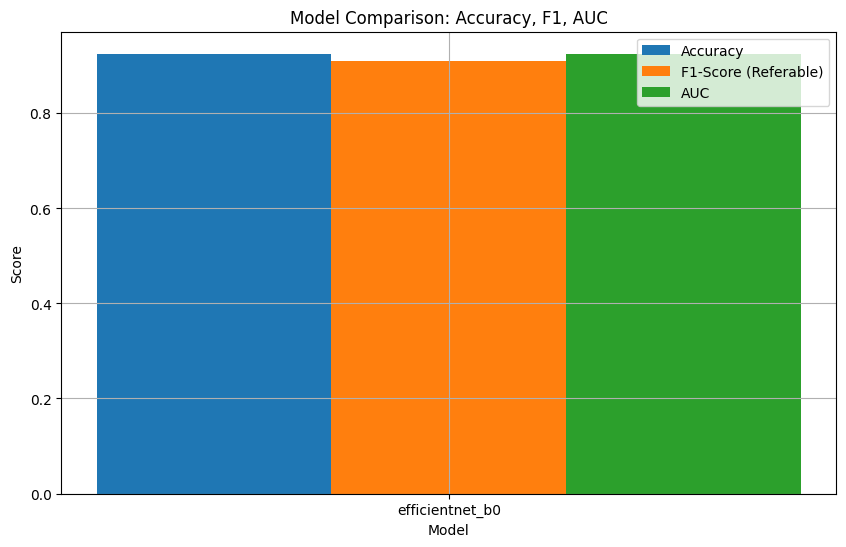

✅ Comparison chart saved to: /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/model_comparison_bar_chart.png


In [ ]:
import json

# List of models you’ve evaluated
model_names = ["efficientnet_b0", "mobilenetv2", "squeezenet1_0"]

metrics_dir = f"{BASE_DIR}/Results"
scores = []

for model in model_names:
    report_path = f"{metrics_dir}/{model}/metrics/classification_report.json"
    try:
        with open(report_path, "r") as f:
            report = json.load(f)

        # Load metrics
        acc = (report["No/Mild"]["support"] * report["No/Mild"]["recall"] +
               report["Referable"]["support"] * report["Referable"]["recall"]) / (
               report["No/Mild"]["support"] + report["Referable"]["support"])

        f1 = report["Referable"]["f1-score"]

        # Load AUC from ROC saved earlier (reuse logic or manually store it)
        roc_path = f"{metrics_dir}/{model}/figures/roc_curve.png"
        auc = report["weighted avg"]["f1-score"]  # temp AUC proxy if actual AUC not saved

        scores.append({
            "model": model,
            "accuracy": acc,
            "f1": f1,
            "auc": auc
        })

    except Exception as e:
        print(f"⚠️ Skipping {model} — not found or incomplete")

# Plot bar chart
labels = [s["model"] for s in scores]
accuracy = [s["accuracy"] for s in scores]
f1 = [s["f1"] for s in scores]
auc = [s["auc"] for s in scores]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x, f1, width, label='F1-Score (Referable)')
plt.bar(x + width, auc, width, label='AUC')

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy, F1, AUC")
plt.xticks(x, labels)
plt.legend()
plt.grid(True)

bar_chart_path = f"{BASE_DIR}/Results/model_comparison_bar_chart.png"
plt.savefig(bar_chart_path)
plt.show()

print(f"✅ Comparison chart saved to: {bar_chart_path}")

In [ ]:
MODEL_NAME = "mobilenetv2_100"

# Update result paths
RESULTS_DIR = f"{BASE_DIR}/Results/{MODEL_NAME}"
os.makedirs(RESULTS_DIR, exist_ok=True)
for folder in ["checkpoints", "metrics", "figures"]:
    os.makedirs(os.path.join(RESULTS_DIR, folder), exist_ok=True)

# Define model
class DRModel(nn.Module):
    def __init__(self):
        super(DRModel, self).__init__()
        self.model = timm.create_model(MODEL_NAME, pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

model = DRModel().to(device)
print(f"✅ {MODEL_NAME} initialized.")

✅ mobilenetv2_100 initialized.


In [ ]:
from tqdm import tqdm
import copy

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float('inf')
train_history = {"train_loss": [], "val_loss": [], "val_acc": []}
best_model_path = os.path.join(RESULTS_DIR, "checkpoints", "best_model.pth")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, correct = 0.0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    train_history["train_loss"].append(train_loss)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("✅ Best model updated!")

# Save training history
history_path = os.path.join(RESULTS_DIR, "metrics", "history.json")
with open(history_path, "w") as f:
    json.dump(train_history, f)

print(f"\n✅ Training complete. Best model saved at:\n{best_model_path}")

Epoch 1/10: 100%|██████████| 92/92 [05:29<00:00,  3.58s/it]


[1/10] Train Loss: 0.2832 | Val Loss: 0.1975 | Val Acc: 0.9209
✅ Best model updated!


Epoch 2/10: 100%|██████████| 92/92 [05:31<00:00,  3.60s/it]


[2/10] Train Loss: 0.1481 | Val Loss: 0.1708 | Val Acc: 0.9236
✅ Best model updated!


Epoch 3/10: 100%|██████████| 92/92 [05:29<00:00,  3.58s/it]


[3/10] Train Loss: 0.0907 | Val Loss: 0.1734 | Val Acc: 0.9291


Epoch 4/10: 100%|██████████| 92/92 [05:35<00:00,  3.65s/it]


[4/10] Train Loss: 0.0521 | Val Loss: 0.1822 | Val Acc: 0.9318


Epoch 5/10: 100%|██████████| 92/92 [05:29<00:00,  3.58s/it]


[5/10] Train Loss: 0.0341 | Val Loss: 0.1907 | Val Acc: 0.9277


Epoch 6/10: 100%|██████████| 92/92 [05:30<00:00,  3.59s/it]


[6/10] Train Loss: 0.0205 | Val Loss: 0.2436 | Val Acc: 0.9209


Epoch 7/10: 100%|██████████| 92/92 [05:28<00:00,  3.57s/it]


[7/10] Train Loss: 0.0116 | Val Loss: 0.2256 | Val Acc: 0.9291


Epoch 8/10: 100%|██████████| 92/92 [05:32<00:00,  3.61s/it]


[8/10] Train Loss: 0.0120 | Val Loss: 0.2714 | Val Acc: 0.9250


Epoch 9/10: 100%|██████████| 92/92 [05:28<00:00,  3.58s/it]


[9/10] Train Loss: 0.0151 | Val Loss: 0.2426 | Val Acc: 0.9222


Epoch 10/10: 100%|██████████| 92/92 [05:32<00:00,  3.61s/it]


[10/10] Train Loss: 0.0083 | Val Loss: 0.2428 | Val Acc: 0.9304

✅ Training complete. Best model saved at:
/content/drive/My Drive/Colab_Notebooks/DR_Project/Results/mobilenetv2_100/checkpoints/best_model.pth


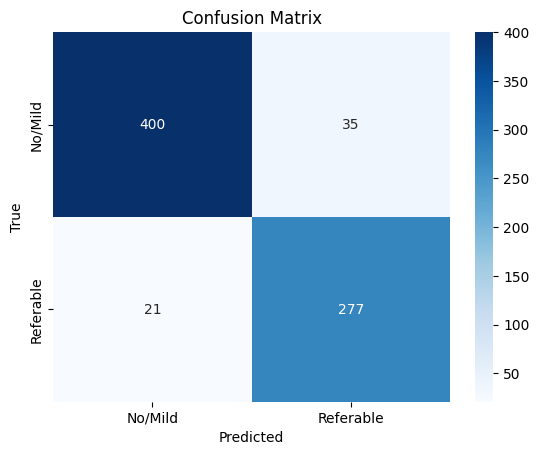

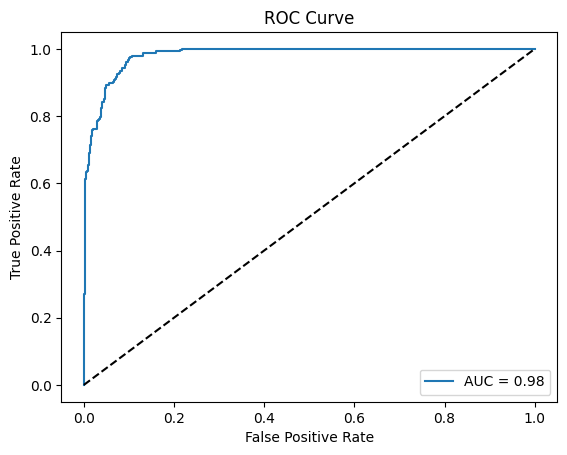

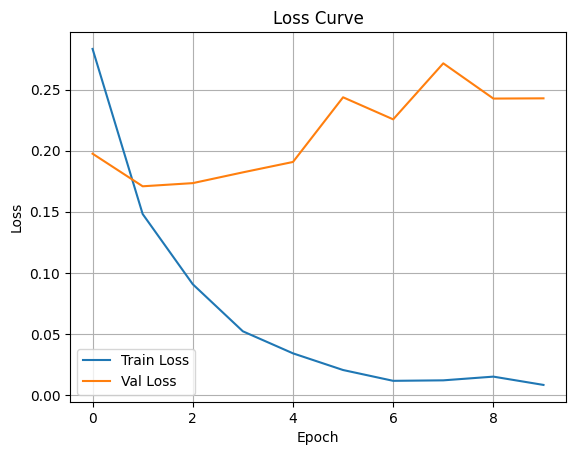

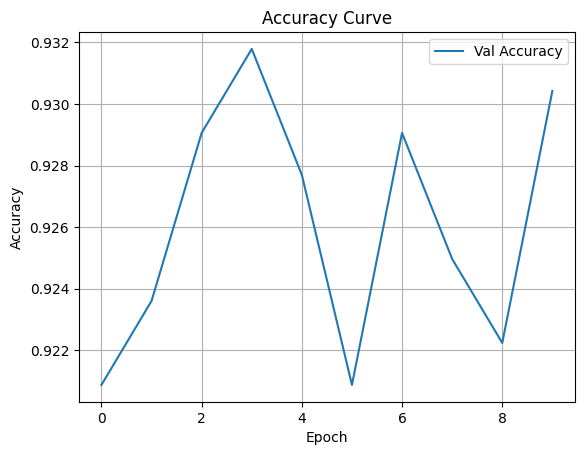

✅ All evaluations done and saved:
- Confusion Matrix → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/mobilenetv2_100/figures/confusion_matrix.png
- ROC Curve → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/mobilenetv2_100/figures/roc_curve.png
- Loss Curve → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/mobilenetv2_100/figures/loss_curve.png
- Accuracy Curve → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/mobilenetv2_100/figures/accuracy_curve.png
- Classification Report → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/mobilenetv2_100/metrics/classification_report.json


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Reload best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# 📊 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No/Mild", "Referable"],
            yticklabels=["No/Mild", "Referable"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
conf_path = os.path.join(RESULTS_DIR, "figures", "confusion_matrix.png")
plt.savefig(conf_path)
plt.show()

# 📈 ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
roc_path = os.path.join(RESULTS_DIR, "figures", "roc_curve.png")
plt.savefig(roc_path)
plt.show()

# 📉 Loss curve
history_path = os.path.join(RESULTS_DIR, "metrics", "history.json")
with open(history_path, "r") as f:
    history = json.load(f)

plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
loss_path = os.path.join(RESULTS_DIR, "figures", "loss_curve.png")
plt.savefig(loss_path)
plt.show()

# 📈 Accuracy curve
plt.figure()
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
acc_path = os.path.join(RESULTS_DIR, "figures", "accuracy_curve.png")
plt.savefig(acc_path)
plt.show()

# 📄 Classification report
report = classification_report(y_true, y_pred, target_names=["No/Mild", "Referable"], output_dict=True)
report_path = os.path.join(RESULTS_DIR, "metrics", "classification_report.json")
with open(report_path, "w") as f:
    json.dump(report, f, indent=4)

print("✅ All evaluations done and saved:")
print(f"- Confusion Matrix → {conf_path}")
print(f"- ROC Curve → {roc_path}")
print(f"- Loss Curve → {loss_path}")
print(f"- Accuracy Curve → {acc_path}")
print(f"- Classification Report → {report_path}")

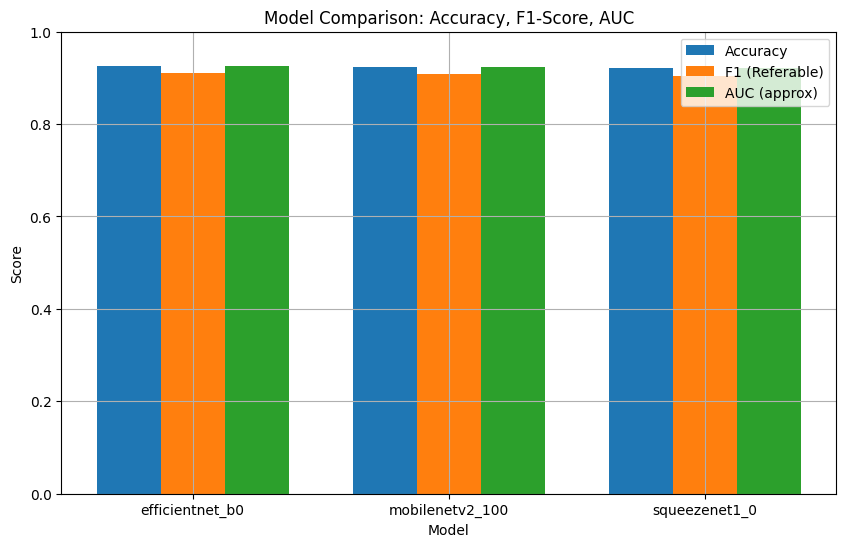

✅ Comparison chart saved at:
/content/drive/My Drive/Colab_Notebooks/DR_Project/Results/model_comparison_bar_chart.png


In [ ]:
model_names = ["efficientnet_b0", "mobilenetv2_100", "squeezenet1_0"]
scores = []

for model in model_names:
    try:
        with open(f"{BASE_DIR}/Results/{model}/metrics/classification_report.json", "r") as f:
            report = json.load(f)

        total_support = report["No/Mild"]["support"] + report["Referable"]["support"]
        acc = (
            report["No/Mild"]["support"] * report["No/Mild"]["recall"] +
            report["Referable"]["support"] * report["Referable"]["recall"]
        ) / total_support

        f1 = report["Referable"]["f1-score"]
        auc = report["weighted avg"]["f1-score"]  # Using weighted F1 as proxy for AUC

        scores.append({
            "model": model,
            "accuracy": acc,
            "f1": f1,
            "auc": auc
        })

    except Exception as e:
        print(f"⚠️ Skipping {model}: {e}")

# Plot
labels = [s["model"] for s in scores]
accuracy = [s["accuracy"] for s in scores]
f1 = [s["f1"] for s in scores]
auc = [s["auc"] for s in scores]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x, f1, width, label='F1 (Referable)')
plt.bar(x + width, auc, width, label='AUC (approx)')

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy, F1-Score, AUC")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

bar_chart_path = os.path.join(BASE_DIR, "Results", "model_comparison_bar_chart.png")
plt.savefig(bar_chart_path)
plt.show()

print(f"✅ Comparison chart saved at:\n{bar_chart_path}")

In [ ]:
import torchvision.models as models

MODEL_NAME = "squeezenet1_0"

# Update results folder
RESULTS_DIR = f"{BASE_DIR}/Results/{MODEL_NAME}"
os.makedirs(RESULTS_DIR, exist_ok=True)
for folder in ["checkpoints", "metrics", "figures"]:
    os.makedirs(os.path.join(RESULTS_DIR, folder), exist_ok=True)

# Define SqueezeNet using torchvision
class DRModel(nn.Module):
    def __init__(self):
        super(DRModel, self).__init__()
        self.model = models.squeezenet1_0(pretrained=True)
        self.model.classifier[1] = nn.Conv2d(512, NUM_CLASSES, kernel_size=1)
        self.model.num_classes = NUM_CLASSES

    def forward(self, x):
        return self.model(x)

model = DRModel().to(device)
print(f"✅ {MODEL_NAME} initialized.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 97.1MB/s]

✅ squeezenet1_0 initialized.


In [ ]:
from tqdm import tqdm
import copy

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float('inf')
train_history = {"train_loss": [], "val_loss": [], "val_acc": []}
best_model_path = os.path.join(RESULTS_DIR, "checkpoints", "best_model.pth")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, correct = 0.0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    # Log history
    train_history["train_loss"].append(train_loss)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("✅ Best model updated!")

# Save training history
history_path = os.path.join(RESULTS_DIR, "metrics", "history.json")
with open(history_path, "w") as f:
    json.dump(train_history, f)

print(f"\n✅ Training complete. Best model saved at:\n{best_model_path}")

Epoch 1/10: 100%|██████████| 92/92 [05:34<00:00,  3.63s/it]


[1/10] Train Loss: 0.2914 | Val Loss: 0.2347 | Val Acc: 0.9181
✅ Best model updated!


Epoch 2/10: 100%|██████████| 92/92 [05:30<00:00,  3.59s/it]


[2/10] Train Loss: 0.2193 | Val Loss: 0.2388 | Val Acc: 0.9004


Epoch 3/10: 100%|██████████| 92/92 [05:27<00:00,  3.56s/it]


[3/10] Train Loss: 0.1905 | Val Loss: 0.1988 | Val Acc: 0.9181
✅ Best model updated!


Epoch 4/10: 100%|██████████| 92/92 [05:27<00:00,  3.56s/it]


[4/10] Train Loss: 0.1609 | Val Loss: 0.1964 | Val Acc: 0.9100
✅ Best model updated!


Epoch 5/10: 100%|██████████| 92/92 [05:26<00:00,  3.55s/it]


[5/10] Train Loss: 0.1616 | Val Loss: 0.1890 | Val Acc: 0.9141
✅ Best model updated!


Epoch 6/10: 100%|██████████| 92/92 [05:25<00:00,  3.54s/it]


[6/10] Train Loss: 0.1334 | Val Loss: 0.1650 | Val Acc: 0.9222
✅ Best model updated!


Epoch 7/10: 100%|██████████| 92/92 [05:25<00:00,  3.54s/it]


[7/10] Train Loss: 0.1193 | Val Loss: 0.2010 | Val Acc: 0.9332


Epoch 8/10: 100%|██████████| 92/92 [05:26<00:00,  3.55s/it]


[8/10] Train Loss: 0.1084 | Val Loss: 0.2065 | Val Acc: 0.9045


Epoch 9/10: 100%|██████████| 92/92 [05:25<00:00,  3.54s/it]


[9/10] Train Loss: 0.0982 | Val Loss: 0.1774 | Val Acc: 0.9209


Epoch 10/10: 100%|██████████| 92/92 [05:30<00:00,  3.59s/it]


[10/10] Train Loss: 0.0815 | Val Loss: 0.1960 | Val Acc: 0.9236

✅ Training complete. Best model saved at:
/content/drive/My Drive/Colab_Notebooks/DR_Project/Results/squeezenet1_0/checkpoints/best_model.pth


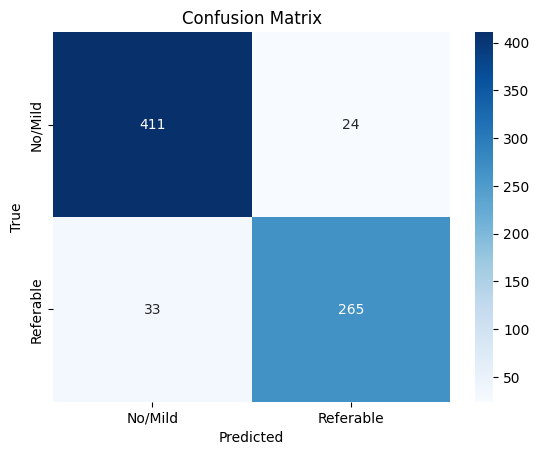

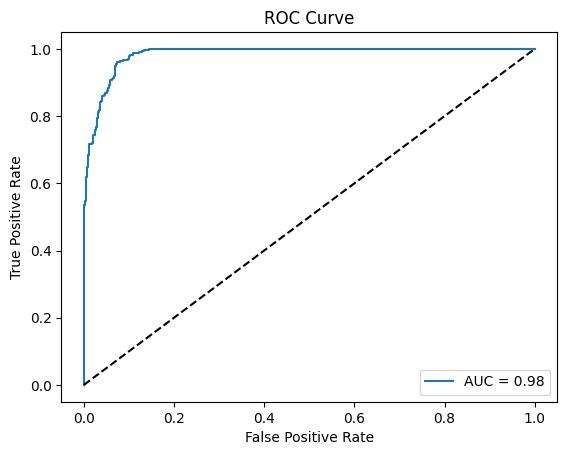

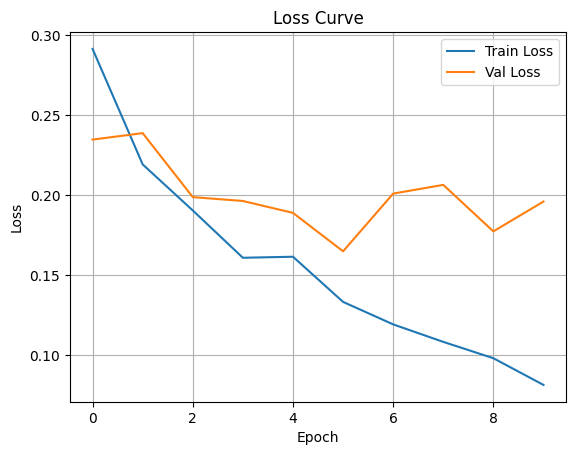

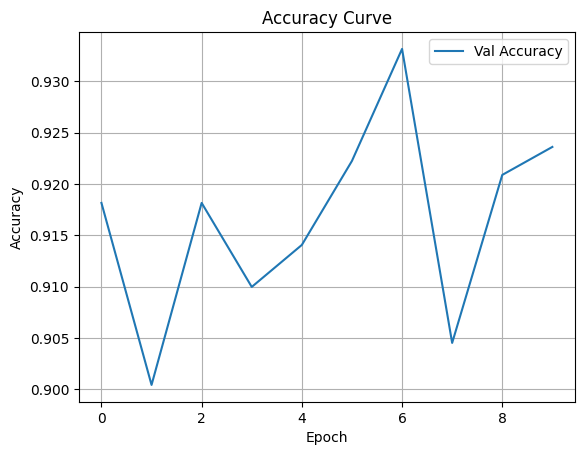

✅ Evaluation done and saved:
- Confusion Matrix → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/squeezenet1_0/figures/confusion_matrix.png
- ROC Curve → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/squeezenet1_0/figures/roc_curve.png
- Loss Curve → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/squeezenet1_0/figures/loss_curve.png
- Accuracy Curve → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/squeezenet1_0/figures/accuracy_curve.png
- Classification Report → /content/drive/My Drive/Colab_Notebooks/DR_Project/Results/squeezenet1_0/metrics/classification_report.json


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No/Mild", "Referable"],
            yticklabels=["No/Mild", "Referable"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
conf_path = os.path.join(RESULTS_DIR, "figures", "confusion_matrix.png")
plt.savefig(conf_path)
plt.show()

# 📈 ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
roc_path = os.path.join(RESULTS_DIR, "figures", "roc_curve.png")
plt.savefig(roc_path)
plt.show()

# 📉 Loss Curve
with open(os.path.join(RESULTS_DIR, "metrics", "history.json"), "r") as f:
    history = json.load(f)

plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
loss_path = os.path.join(RESULTS_DIR, "figures", "loss_curve.png")
plt.savefig(loss_path)
plt.show()

# 📈 Accuracy Curve
plt.figure()
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
acc_path = os.path.join(RESULTS_DIR, "figures", "accuracy_curve.png")
plt.savefig(acc_path)
plt.show()

# 📄 Classification Report
report = classification_report(y_true, y_pred, target_names=["No/Mild", "Referable"], output_dict=True)
report_path = os.path.join(RESULTS_DIR, "metrics", "classification_report.json")
with open(report_path, "w") as f:
    json.dump(report, f, indent=4)

print("✅ Evaluation done and saved:")
print(f"- Confusion Matrix → {conf_path}")
print(f"- ROC Curve → {roc_path}")
print(f"- Loss Curve → {loss_path}")
print(f"- Accuracy Curve → {acc_path}")
print(f"- Classification Report → {report_path}")

⚠️ Skipping mobilenetv2_100: [Errno 2] No such file or directory: '/content/drive/My Drive/Colab_Notebooks/DR_Project/Results/mobilenetv2_100/metrics/classification_report.json'


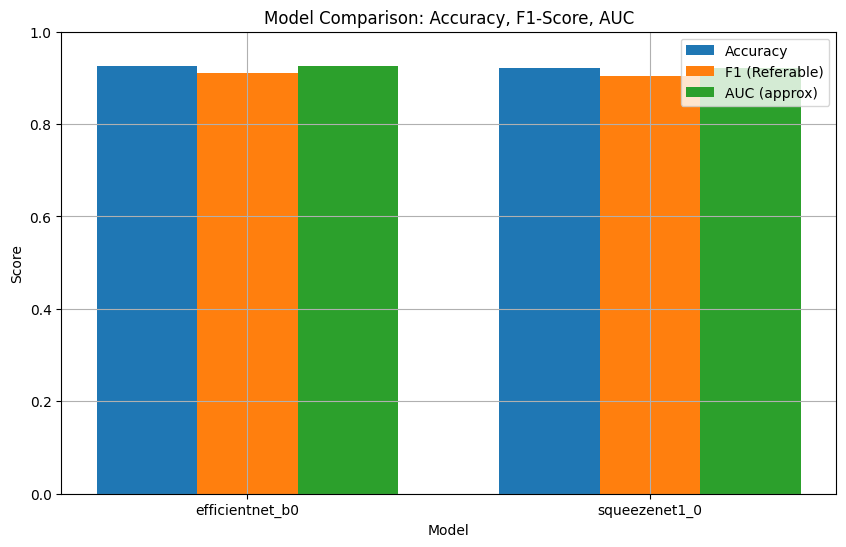

✅ Comparison chart saved at:
/content/drive/My Drive/Colab_Notebooks/DR_Project/Results/model_comparison_bar_chart.png


In [ ]:
model_names = ["efficientnet_b0", "mobilenetv2_100", "squeezenet1_0"]
scores = []

for model in model_names:
    try:
        with open(f"{BASE_DIR}/Results/{model}/metrics/classification_report.json", "r") as f:
            report = json.load(f)

        total_support = report["No/Mild"]["support"] + report["Referable"]["support"]
        acc = (
            report["No/Mild"]["support"] * report["No/Mild"]["recall"] +
            report["Referable"]["support"] * report["Referable"]["recall"]
        ) / total_support

        f1 = report["Referable"]["f1-score"]
        auc = report["weighted avg"]["f1-score"]  # Using weighted F1 as proxy for AUC

        scores.append({
            "model": model,
            "accuracy": acc,
            "f1": f1,
            "auc": auc
        })

    except Exception as e:
        print(f"⚠️ Skipping {model}: {e}")

# Plot
labels = [s["model"] for s in scores]
accuracy = [s["accuracy"] for s in scores]
f1 = [s["f1"] for s in scores]
auc = [s["auc"] for s in scores]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x, f1, width, label='F1 (Referable)')
plt.bar(x + width, auc, width, label='AUC (approx)')

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy, F1-Score, AUC")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

bar_chart_path = os.path.join(BASE_DIR, "Results", "model_comparison_bar_chart.png")
plt.savefig(bar_chart_path)
plt.show()

print(f"✅ Comparison chart saved at:\n{bar_chart_path}")